In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 5.9MB 44.2MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from torch.nn import CrossEntropyLoss,BCELoss
import math
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from concurrent.futures import ThreadPoolExecutor,as_completed
from sklearn.manifold import TSNE
import torch.nn.functional as F
from torch.nn import Module,Linear,Dropout,LayerNorm,BatchNorm1d,Conv1d,LeakyReLU,MaxPool1d,GRU
import torchvision.models as models
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor,as_completed
import albumentations as aug
from datetime import datetime
import cv2
import torch.nn
import soundfile as sf
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
from torch.utils.data import DataLoader
from torch.nn import Module,Sequential,init  
from torch.nn import Dropout,Linear,Flatten,Softmax,Conv2d,LSTM,AdaptiveAvgPool2d,Parameter
from torch.optim import Adagrad,Adam
import random
import torch
import zipfile
import librosa

In [ ]:
filename="vox1"

In [ ]:
url='/content/drive//MyDrive/'+filename+'.zip'
with zipfile.ZipFile(url) as zf:
       for member in tqdm(zf.infolist(), desc='Extracting '):
             zf.extract(member, './')
        

In [ ]:

class CrossEntropy(Module):
    def forward(self, x, target):
       
        return F.cross_entropy(x,target)


class ArcMarginProduct(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine
class Angular(Module):

    def __init__(self, embedding_size, no_Classes):
      
        super(Angular, self).__init__()
        
        self.arc_margin_product  =ArcMarginProduct(embedding_size,no_Classes)
        self.head=Linear(embedding_size, no_Classes, bias=False)
        self.metric_crit = Arcface()
        self.crit = CrossEntropy() 
        self.coeff=0.2
     
    def metric_classify(self, embedding):
        return self.arc_margin_product(embedding)

    def classify(self, embedding):
      
      code_norm = embedding.norm(p=2,dim=1, keepdim=True) / 10.
      code = torch.div(embedding, code_norm)
      out = self.head(code) 
      return out  


    def forward(self, embedding, labels):
        metric_output = self.metric_classify(embedding)
        metric_loss = self.metric_crit(metric_output, labels)

        output = self.classify(embedding)
        loss = self.crit(output, labels)


        return loss * (1 - self.coeff) + metric_loss * self.coeff, output


       


  

In [ ]:

class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self, s=16.0, m=0.5):
        super(Arcface, self).__init__()
     
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
       
        self.threshold = math.cos(math.pi - m)
    def forward(self, x, label):
        # weights norm
        nB = len(x)
     
        cos_theta = x.clamp(-1,1) # for numerical stability
        
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1.000001 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
       
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        
        
        loss=F.cross_entropy(output,label)


        return loss

In [ ]:
def get_items(src_dir):
    '''
    Designed for VoxCeleb
    '''
    l_utt = []
    for i,(path, dirs, files) in enumerate(os.walk(src_dir)):
        if(i%5000==0):
           print(i)

        base=path
        #base ='/'+ '/'.join(path.split('/')[-2:])+'/'
        #assert(1==2)
        base=base.replace('\\', '/')
        
        
        for file in files:
            if file[-3:] != 'wav':
                continue
            l_utt.append(base+'/'+file)
    return l_utt

def get_dictionary(l_utt):
    d_label = {}
    idx_counter = 0
    for utt in l_utt:
        spk = utt.split('/')[2]
        if spk not in d_label:
            d_label[spk] = idx_counter
            idx_counter += 1
    return d_label

In [ ]:
class Generator():
    
    
    def __init__(self,items,class_dic,max_aud_len,shuffle=False,triplet=False):
       
        
        self.shuffle=True 
        self.items=items
        self.classs=class_dic
        random.shuffle(self.items)
        self.audlen=max_aud_len*16000
        
        self.need_path=False
        
        

    def no_Class(self):
        return len(self.classs)
    def __len__(self):
        return len(self.items)
    
    def read_data(self,path):
        audio, samplerate = librosa.load(path, sr = 16000)      
        
        return audio        
            
    def epochover(self):
        print("shuffled")
        random.shuffle(self.items)
        
    def __getitem__(self,itm_no):
       
        path = self.items[itm_no]# get the set of record of the batchno
        audio=self.read_data(path)
        clas=path.split('/')[2]
        # proprocess functions
        clas=self.classs[clas]
        
        if(self.audlen<len(audio)):
            audio=audio[:self.audlen]
        pad=self.audlen-len(audio)
        aud=np.zeros(self.audlen)
        aud[:len(audio)]=audio
        audio=aud
            
        audio=np.reshape(audio,(1,-1))  
        if(self.need_path==False):
            return {
                  "X":torch.tensor(audio,dtype=torch.float32),
                 "op":torch.tensor(clas)   
                 #"path":path                         
                  } 
        else:
            return {
                  "X":torch.tensor(audio,dtype=torch.float32),
                 "op":torch.tensor(clas), 
                 "path":path                         
                  } 

In [ ]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            #msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
            
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)
        

        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

      
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);


        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

 


    def forward(self, waveforms):
        

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz  + torch.abs(self.low_hz_)
        
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)

        
        band_pass = band_pass / (2*band[:,None])
        

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1) 

class Identiy(Module):
   def __init__(self):
      super().__init__()
      pass
   def forward(self,X):
        return X   
    
    
class Resnet1D(Module):
   def __init__(self,filters):
      super().__init__()
      self.conv1=Conv1d(filters[0],filters[1],kernel_size=(3),padding=1)
      self.norm1=BatchNorm1d(num_features=filters[1])
      self.act1=LeakyReLU()

      self.conv2=Conv1d(filters[1],filters[1],kernel_size=(3),padding=1)
      self.norm2=BatchNorm1d(num_features=filters[1])

      if(filters[0]!=filters[1]): 
           self.convr=Conv1d(filters[0],filters[1],kernel_size=(1),padding=0)
      else:
          self.convr=Identiy()     
      self.normr=BatchNorm1d(num_features=filters[1])
      self.actr=LeakyReLU()

      self.pool=MaxPool1d(3)



   def forward(self,X):

     y=self.conv1(X)
     y=self.norm1(y)
     y=self.act1(y)

     y=self.conv2(y)
     y=self.norm2(y)

     res=self.convr(X)
     res=self.normr(res)

     y=torch.add(y,res)
     y=self.actr(y)

     y=self.pool(y)  
     

     return y   

class Utterance_Block(Module):
   def __init__(self,in_dim,out_dim):
     
      super().__init__()
      self.bn_before_gru = BatchNorm1d(in_dim)
      self.relu=LeakyReLU(negative_slope = 0.3)
      self.l1=Linear(in_dim,512)
      self.rnn=GRU(512,512,bidirectional=True)

      self.l2=Linear(1024,out_dim)
      self.norm1=BatchNorm1d(num_features=out_dim)

   def forward(self,X):


    y=self.bn_before_gru(X)
    y=self.relu(y)
   
    y = y.permute(0,2, 1)
    b=y.shape[2]
    y=self.l1(y)
    self.rnn.flatten_parameters()    
    y,_=self.rnn(y)    
    y=torch.sum(y,1)
    y=torch.div(y,b)
    y=self.l2(y) 
    

   

    return y
class Rawnet(Module):
   def __init__(self,embedding_dimension,no_clas):
     super().__init__() 
     self.block1= SincConv_fast(in_channels = 1,out_channels = 128,kernel_size =251)

     self.block2=Resnet1D([128,128])
     self.block3=Resnet1D([128,128]) 

     self.block4=Resnet1D([128,256])
     self.block5=Resnet1D([256,256])
     self.block6=Resnet1D([256,512])
     self.block7=Resnet1D([512,512])

     self.utter_blk=Utterance_Block(512,512)
     self.classs=no_clas
     self.embedding_dimension=embedding_dimension
     self.lossfn=Angular(embedding_dimension, no_clas)
     
     
   
    
   def accuracy(self,predictions, labels):
      classes = torch.argmax(predictions, dim=1)
      return torch.mean((classes == labels).float())   
  
    
   def forward(self,X):

     y=self.block1(X)

     y=self.block2(y)  
     y=self.block3(y) 
 
     y=self.block4(y)  
     y=self.block5(y)  
     y=self.block6(y)  
     y=self.block7(y)  

     features=self.utter_blk(y)  

     
     return features 

In [ ]:
def count_parameters(model):
    total=sum(p.numel() for p in model.parameters())
    trainable= sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen=sum(p.numel() for p in model.parameters() if  p.requires_grad==False)
    print("total parameters :",total,"    trainable parameters :",trainable,"    frozen parameters :",frozen)

In [ ]:
class Training_pipeline():
    def __init__(self,model,processing_unit):
        
     self.device = torch.device(processing_unit)
     self.model=model
     

     
     self.model.to(self.device)
    def compiler(self,optimizer,lr=0.001):
     
      self.optim = optim.Adam(self.model.parameters(),lr=0.0001)
         


            
def fit(self,data_generator,epochs,batch_size,save_best=False):
     self.generator= data_generator
     train_data_loader = DataLoader(data_generator, batch_size=batch_size,shuffle=True, num_workers=4)
     #validate_data_loader= DataLoader(val_generator, batch_size=batch_size, num_workers=4)
     best_acc = 0
     print("training")   
     self.model.train()
     count_parameters(self.model)
     for epoch in range(epochs):
                 final_loss=0
                 final_acc=0
                 avgacc=[]
                 avglss=[]
                 train_data_loader.dataset.epochover()
                 t=tqdm(train_data_loader,total=len(train_data_loader))
                 
                 for data in t:
                       for key,value in data.items():
                             data[key]=value.to(self.device)
                             
                       self.optim.zero_grad()
                       
                       inp,target=data['X'],data['op']
                       
                       features=self.model(inp)
                       #print(features.shape)
                       #print(self.model_loss(label, target) , self.loss_weight * self.center_loss(target, features))
                       loss,label = self.model.lossfn(features, target)
                       #loss =  self.loss_weight * self.center_loss(target, features)
                       acc=self.model.accuracy(label,target)
           
                       
                       loss.backward()

                       self.optim.step()
                        
                       avgacc.append(acc.item())
                       avglss.append(loss.item())
                        
                       string="epoch  "+str(epoch)+"   loss: {:.4f}".format(sum(avglss)/len(avglss))+"   avg: {:.4f}".format(sum(avgacc)/len(avgacc))  
                       t.set_description(string)
                       t.refresh() 
                       final_loss+=loss.item() 
                       final_acc+=acc.item()                        
                     

                                                       
                
               
                 
                 print("epoch :  ",epoch,"loss :  ",final_loss/len(train_data_loader),"  accuracy :  ",final_acc/len(train_data_loader))
                 if(final_acc>best_acc):
                      torch.save(self.model.state_dict(),save_best)
                      best_acc=final_acc
                
Training_pipeline.fit=fit 

def evaluate(self,data_generator,batch_size):
      self.generator= data_generator
      train_data_loader = DataLoader(data_generator, batch_size=batch_size,shuffle=True, num_workers=4)
      #validate_data_loader= DataLoader(val_generator, batch_size=batch_size, num_workers=4)
      print("evaluating")   
      self.model.eval()
      count_parameters(self.model)
      final_loss=0
      final_acc=0
      avgacc=[]
      avglss=[]
      train_data_loader.dataset.epochover()
      t=tqdm(train_data_loader,total=len(train_data_loader))
      
      for data in t:
            for key,value in data.items():
                  data[key]=value.to(self.device)
                  
            
            inp,target=data['X'],data['op']
            
            features=self.model(inp)
            loss,label = self.model.lossfn(features, target)
            acc=self.model.accuracy(label,target)

      
            
            avgacc.append(acc.item())
            avglss.append(loss.item())
            
            string="   loss: {:.4f}".format(sum(avglss)/len(avglss))+"   avg: {:.4f}".format(sum(avgacc)/len(avgacc))  
            t.set_description(string)
            t.refresh() 
            final_loss+=loss.item() 
            final_acc+=acc.item()      
      print("evaluation :  ""loss :  ",final_loss/len(train_data_loader),"  accuracy :  ",final_acc/len(train_data_loader))

Training_pipeline.evaluate=evaluate 



In [ ]:

def sortid(ids):
    return int(ids.split('/')[2].replace('id',''))

In [ ]:
if __name__ == '__main__': 
    
    
    #items=get_items('./wav/')[130000:140500]
  
    items=get_items('./wav/')
    items=sorted(items,key=sortid)[:120000]
    config={"e":100,"b":60,"lr":0.001}
 



    
    #random.shuffle(items)
 
    
 
    
    dicts=get_dictionary(items)
    print(len(dicts.keys()),len(items))
    train=Generator(items,dicts,4)
    #print(dicts)
    #val=Generator(valset,get_dictionary(valset),4)
    
    component=Rawnet(512,1020)

    #component.load_state_dict(torch.load('/content/drive/MyDrive/spkrecog16.pth'))
   
    
   
     
    
    Model=Training_pipeline(component,"cuda")
    Model.compiler("AdamW",config["lr"]) 
    #Model.fit(train,config["e"],config["b"],save_best='/content/drive/MyDrive/spkrecog.pth')

0
5000
10000
15000
20000
983 120000


In [ ]:
component.load_state_dict(torch.load('/content/drive/MyDrive/spkrecog.pth'))

<All keys matched successfully>

In [ ]:
Model.fit(train,10,32,save_best='/content/drive/MyDrive/spkrecog.pth')

In [ ]:
Model.evaluate(train,16)

In [ ]:
component.load_state_dict(torch.load('/content/drive/MyDrive/spkrecog.pth'))

<All keys matched successfully>

In [ ]:

class Tripletgenearator():
    def __init__(self,generator,count=50,shuffle=False):
        
        self.tripletsets={i:list() for i in range(generator.no_Class())}
        self.length=len(generator)
        self.generator=generator
        self.generator.need_path=True
        self.shuffle=shuffle
       
        for i in range(len(generator)):
            path=generator.items[i]
            clas=path.split('/')[2]
            clas=generator.classs[clas]
            self.tripletsets[clas].append([path,i])
        self.allcombsamples=[]    
        for k,v in self.tripletsets.items():
           i=0 
           while(i < count):
               s1=random.choice(v)
               s2=random.choice(v)
               label=1
               if(s1[0]!=s2[0]):
                  self.allcombsamples.append([s1,s2,label])
                  i+=1
               
           for k1 in random.sample(self.tripletsets.keys(),count):
               v1=self.tripletsets[k1]
               s1=random.choice(v)
               s2=random.choice(v1)
               if(k==k1):
                   label=1
               else:
                   label=0
               self.allcombsamples.append([s1,s2,label]) 
               
              
        
               
        print(len(self.allcombsamples),len(self.tripletsets.keys()))       
        for k,v in self.tripletsets.items():
              if(len(v)<=1):
                  print(k)
              assert(len(v)>1)# size 1 or 0 leads to problem in triplet loss
    def __len__(self):
        #return self.length
        return len(self.allcombsamples)
    def epochover(self):
     if(self.shuffle):
      
      
      if(self.shuffle==True):
        self.allcombsamples=[]    
      
        for k,v in self.tripletsets.items():
           i=0 
           while(i < min(len(v),20)):
               s1=random.choice(v)
               s2=random.choice(v)
               label=1
               if(s1[0]!=s2[0]):
                  self.allcombsamples.append([s1,s2,label])
                  i+=1
               
           for k1 in random.sample(self.tripletsets.keys(),200):
               v1=self.tripletsets[k1]
               s1=random.choice(v)
               s2=random.choice(v1)
               if(k==k1):
                   label=1
               else:
                   label=0
               self.allcombsamples.append([s1,s2,label]) 
               
        random.shuffle(self.allcombsamples)
        print('new records created on ',len(self.allcombsamples),"records")      
        
    def __getitem__(self,itemno):
  
        [[s1path, s1id], [s2path, s2id], label]=self.allcombsamples[itemno]
        
        sample1=self.generator[s1id]        
        sample1voice=sample1['X']
        
        sample2=self.generator[s2id]        
        sample2voice=sample2['X']
        
        if((sample1['op']==sample2['op'] and  label==1) or (sample1['op']!=sample2['op'] and  label==0)  ):
        
              return {
                
               "samp1": sample1voice,
               "samp2":sample2voice,
               "label":torch.tensor(label,dtype=torch.float)
                
                }

In [ ]:
class classifier2(Module):
    def __init__(self,in_features):
        super().__init__()

        self.l1=Linear(in_features,1)
    def forward(self,X):
      y=self.l1(X)
      y=torch.sigmoid(y)
      return torch.squeeze(y,0)    
 
        


In [ ]:
class classifier(Module):
    def __init__(self,in_features):
        super().__init__()

        self.l1=Linear(in_features,in_features)
    def forward(Self,X):
      y=self.l1(X)
      y=torch.sigmoid(y)
      return y    

     

In [ ]:
         
class oneshot(Module):
    def __init__(self,base_model):
        super().__init__()
        self.backbone=base_model
        self.classifier=classifier(512)
             
    def forward(self,sample1,sample2):
        #print(sample1.shape)
        emb1=self.backbone(sample1) 
        emb2=self.backbone(sample2)
       

        distance=F.cosine_similarity(emb1, emb2,-1, eps=1e-6)
      

        return distance*0.5+0.5
        #return y
      
    def loss(self, distance, label):
        #distance=torch.relu((distance-0.8)*5)
        #print(distance,label)
        loss=torch.nn.BCELoss()(distance,label)

        return loss
    def accuracy(self,prediction,label):
        a1=torch.tensor(1).to(prediction.device)
        a2=torch.tensor(0).to(prediction.device)
        classes=torch.where(prediction>0.65,a1,a2)
        #classes=torch.argmax(prediction,dim=1)
        print('\n',prediction,label,classes,torch.mean((classes == label).float()))
        
        return torch.mean((classes == label).float())
        
        

        #return torch.mean((torch.argmax(prediction,1) == label).float())

        

In [ ]:
              

class TripletLoss():
   def __init__(self,model,processing_unit):
         self.device = torch.device(processing_unit)
         self.model=model
         self.model.to(self.device)
         
         self.optim= Adam(self.model.parameters(), lr=0.0001)
 
  
   
   def evaluate(self,data_generator):
     self.generator= data_generator
     train_data_loader = DataLoader(data_generator, batch_size=8,shuffle=True, num_workers=4)
     
     print("evaluating")   
     self.model.eval()
     count_parameters(self.model)
     for epoch in range(1):
       
       final_loss=0
       final_acc=0
       avgacc=[]
       #train_data_loader.dataset.epochover()
       t=tqdm(train_data_loader,total=len(train_data_loader))
       for data in t:
          

          for key,value in data.items():
                             data[key]=value.to(self.device)

          prediction=self.model(data["samp1"],data["samp2"])
          target=data['label']
             
            
             
             
             
          loss=self.model.loss(prediction,target)
          acc=self.model.accuracy(prediction, target)
           
          
        
             
          avgacc.append(acc.item())
              
          string="loss: {:.4f}".format(loss)+"acc: {:.4f}".format(acc.item())+" acc: {:.4f}".format(sum(avgacc)/len(avgacc))  
          t.set_description(string)
          t.refresh() 
          final_loss+=loss.item() 
          final_acc+=acc.item()               
                      
                      
       
          
       print("loss : ",final_loss/len(train_data_loader),"  accuracy : ",final_acc/len(train_data_loader))
       
      
   def fit(self,data_generator,epochs,batch_size,save_best=False):
     self.generator= data_generator
     train_data_loader = DataLoader(data_generator, batch_size=batch_size,shuffle=True, num_workers=4)
     best_acc = 0
     
     print("training")   
     self.model.train()
     count_parameters(self.model)
     for epoch in range(epochs):
       
       final_loss=0
       final_acc=0
       avgacc=[]
       #train_data_loader.dataset.epochover()
       t=tqdm(train_data_loader,total=len(train_data_loader))
       for data in t:
          

          for key,value in data.items():
                             data[key]=value.to(self.device)

          self.optim.zero_grad()
          prediction=self.model(data["samp1"],data["samp2"])
          target=data['label']
             
            
             
             
             
          loss=self.model.loss(prediction,target)
          acc=self.model.accuracy(prediction, target)
           
          
          loss.backward()
          self.optim.step()
             
          avgacc.append(acc.item())
              
          string="loss: {:.4f}".format(loss)+"acc: {:.4f}".format(acc.item())+" avg: {:.4f}".format(sum(avgacc)/len(avgacc))  
          t.set_description(string)
          t.refresh() 
          final_loss+=loss.item() 
          final_acc+=acc.item()               
                      
                      
       
          
       print("epoch :  ",epoch,"loss : ",final_loss/len(train_data_loader),"  accuracy : ",final_acc/len(train_data_loader))
       
       torch.save(self.model.state_dict(),save_best)
       if(save_best):torch.save(self.model.state_dict(),save_best)
               
       best_acc = final_acc

In [ ]:
for param in component.parameters():
    param.requires_grad = True


In [ ]:
triplettrain=Tripletgenearator(train,count=200,shuffle=True)     
component.train()  
oneshotmodel=oneshot(component)
#oneshotmodel.load_state_dict(torch.load('/content/drive/MyDrive/modelstriplettest.pth', map_location=torch.device('cpu')))
tripletmodel=TripletLoss(oneshotmodel,"cuda")

393200 983


In [ ]:
tripletmodel.fit(triplettrain,config["e"],16,save_best='/content/drive/MyDrive/modelstriplettest.pth')


In [ ]:
torch.save(oneshotmodel.backbone.state_dict(),'/content/drive/MyDrive/spkrfinal.pth')

In [ ]:
tripletmodel.evaluate(triplettrain)


In [ ]:
def get_embedding(self,i):
    
    inputs=self.traingenerator[i]
    clas=inputs['op']
    ip=torch.unsqueeze(inputs["X"],0)
    self.model.backbone.eval()
    embedding=self.model.backbone(ip)
    embedding=F.normalize(embedding,p=2,dim=1)
    embedding=torch.squeeze(embedding,0).tolist()
    print(i)
   
    
   
    return [embedding,int(clas)]

def rand_hexcolor():
    rgb = ""
    for _ in "RGB":
        i = random.randrange(0, 2**8)
        rgb += i.to_bytes(1, "big").hex()
    return '#'+rgb
    
TripletLoss.get_embedding=get_embedding 

In [ ]:
tripletmodel.traingenerator=train
    
#print(component)
embeddingplot=[]
embeddingclass=[]
        
t1=datetime.now()


for i in range(10000)    :
         
      result=tripletmodel.get_embedding(i)
      embeddingplot.append(result[0])
      embeddingclass.append(result[1])
        
t2=datetime.now()   
print(t2-t1)
    
    
speakers=set(embeddingclass.copy())
spkcol={i:rand_hexcolor() for i in speakers }
    
    
tsne = TSNE(metric='cosine')
embed_tsne = tsne.fit_transform(np.array((embeddingplot)))


Streaming output truncated to the last 5000 lines.
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190

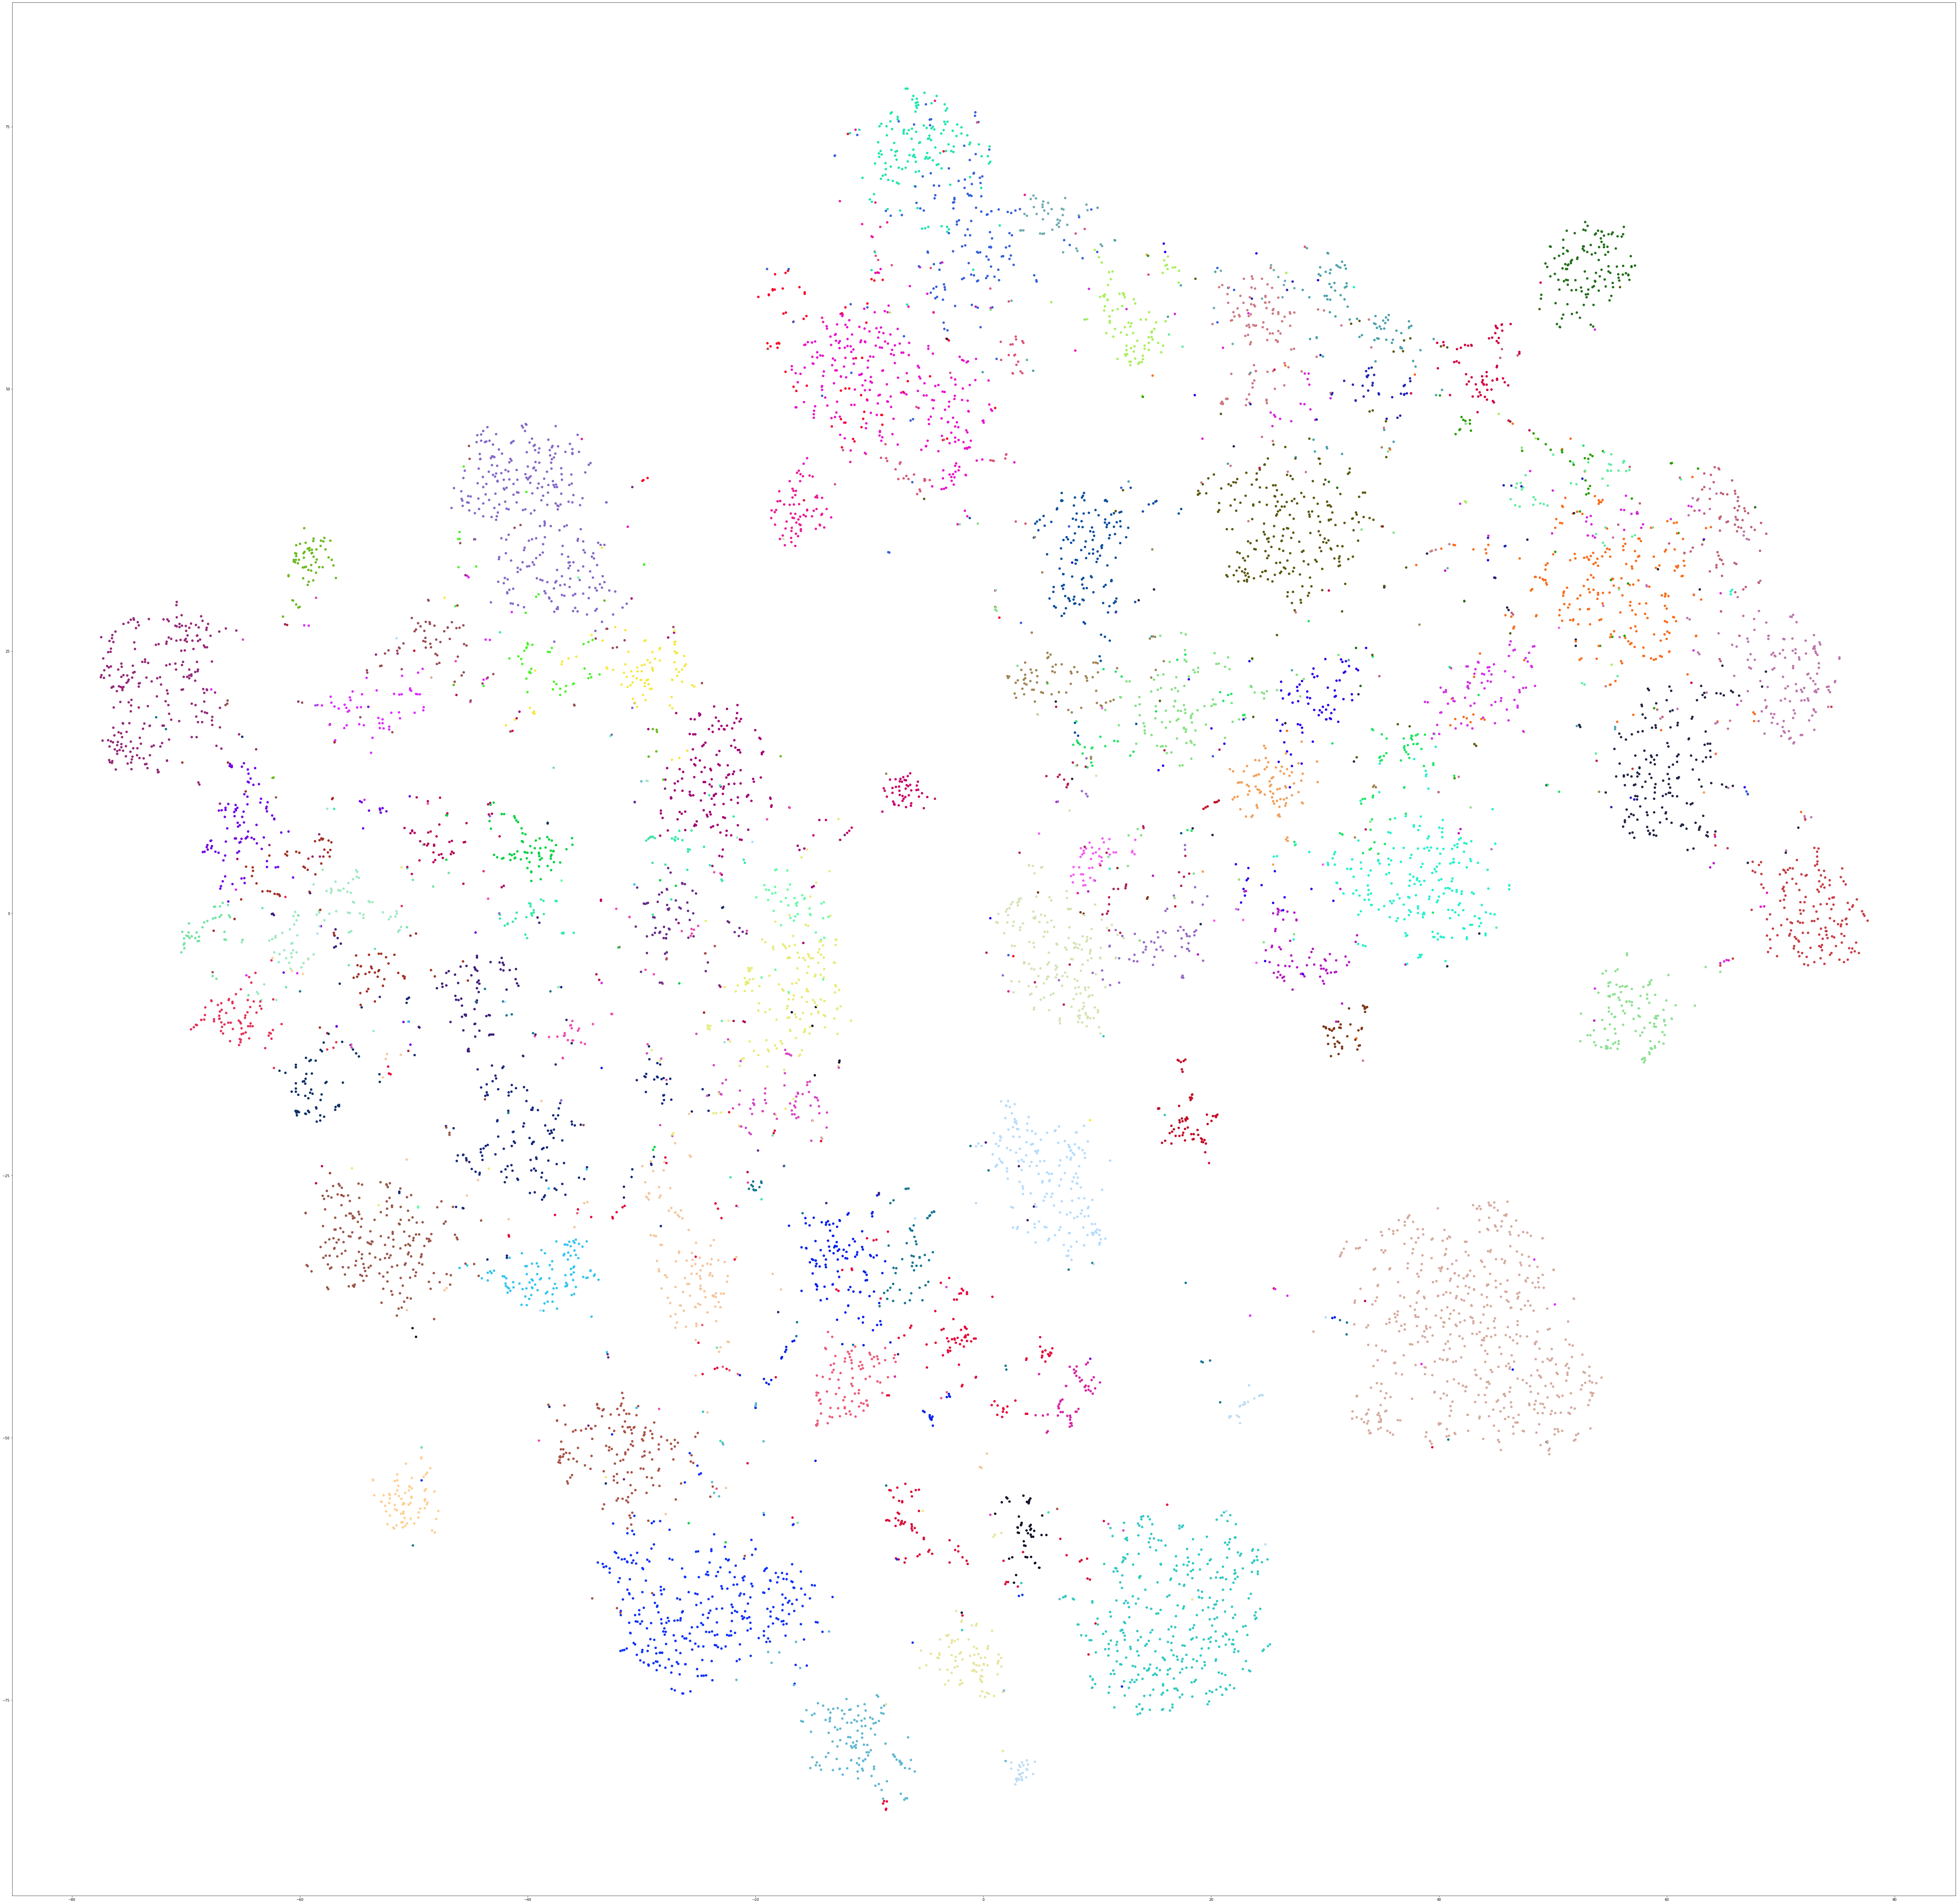

In [ ]:
plt.figure(figsize=(100, 100))

for idx in range(9995):
        plt.scatter(*embed_tsne[idx, :],c=spkcol[embeddingclass[idx]])